In [41]:
import cv2
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import pyocr
import pyocr.builders
import pytesseract

np.set_printoptions(threshold=200)

language = 'eng'
base_path = 'Sample_Book_Pictures/'
img_paths = [base_path + p for p in 
            ['IMG_1436_adjusted.JPG', 'IMG_1436_saturation_contrast.JPG', 
             'IMG_1436_single-label.jpg', 'IMG_1436_single-label-straightened.jpeg',
             'IMG_1437.jpg', 'IMG_1437_cropped.jpg', 'IMG_1437_sliced.JPG',
             'IMG_1437_sliced_rotated.jpg',
            ]]
# 'IMG_1436.jpg',

## pyocr

In [97]:
tools = pyocr.get_available_tools()
print(len(tools))
tool = tools[0]
print(dir(tool))
print()
print(tool.get_available_builders())

1
['CharBoxBuilder', 'DigitBuilder', 'ReOpenableTempfile', 'TESSDATA_EXTENSION', 'TESSERACT_CMD', 'TesseractError', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_set_environment', 'builders', 'can_detect_orientation', 'cleanup', 'codecs', 'detect_orientation', 'digits_only', 'g_creation_flags', 'g_subprocess_startup_info', 'g_version', 'get_available_builders', 'get_available_languages', 'get_name', 'get_version', 'image_to_string', 'is_available', 'logger', 'logging', 'os', 'psm_parameter', 'run_tesseract', 'shutil', 'subprocess', 'sys', 'tempfile']

[<class 'pyocr.builders.LineBoxBuilder'>, <class 'pyocr.builders.TextBuilder'>, <class 'pyocr.builders.WordBoxBuilder'>, <class 'pyocr.tesseract.CharBoxBuilder'>, <class 'pyocr.builders.DigitBuilder'>, <class 'pyocr.builders.DigitLineBoxBuilder'>]


In [ ]:
for ipath in img_paths:
    img = Image.open(ipath)
    size = np.array(img.size)
    
    display(img.reduce(4))
    output = tool.image_to_string(img, lang=language)
#                              builder=pyocr.builders.DigitBuilder())
    print(img.size)
    print(output)
    
    print('smaller version (factor of 2) ------------------')
    new_size = np.array(size/2).astype(int)
    nimg = img.resize(new_size)
    output = tool.image_to_string(nimg, lang=language)
    print(nimg.size)
    print(output)
    
    print('smaller version (factor of 4) ------------------')
    new_size = np.array(size/4).astype(int)
    nimg = img.resize(new_size)
    output = tool.image_to_string(nimg, lang=language)
    print(nimg.size)
    print(output)
    
    print('black and white version ------------------')
    nimg = img.convert('L')
    output = tool.image_to_string(nimg, lang=language)
    print(nimg.size)
    print(output)
    print('==================================')

In [100]:
bw_im = Image.open(img_paths[6]).convert('L')

In [101]:
tool.image_to_string(bw_im)

''

## Exploring Sklearn and Scipy for object detection in image

In [11]:
import sklearn
from skimage import filters, color, io
from scipy import ndimage

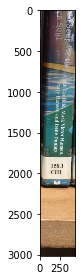

In [12]:
im = io.imread(img_paths[6])
io.imshow(im)

In [13]:
gray_im = color.rgb2gray(im)

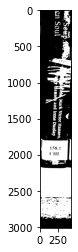

In [17]:
binary_im = np.where(gray_im > 0.5, 1, 0)
binary_im = gray_im > 0.5

plt.imshow(binary_im, cmap = 'gray')

In [19]:
obj_labels, num_labels = ndimage.label(np.invert(binary_im))

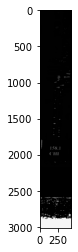

In [20]:
plt.imshow(obj_labels, cmap='gray')

In [21]:
num_labels

253

## Explore edge detection in opencv

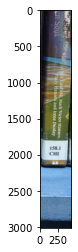

In [38]:
img_num = 6
im = cv2.imread(img_paths[img_num])
plt.imshow(im)

### Binary Images for edge detection

In [ ]:
#exploring binary images effect on line detection
im = cv2.imread(img_paths[img_num])
img_bi = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(img_bi, 200, 255, cv2.THRESH_BINARY)

cv2.imwrite('bwoutput.jpg', im_bw)

sobelx = cv2.Sobel(src=img_bi, ddepth=cv2.CV_8UC1, dx=1, dy=0)
sobely = cv2.Sobel(src=img_bi, ddepth=cv2.CV_8UC1, dx=0, dy=1)

### Sobel for edge detection

In [30]:
#using just sobel for edge detection
im = cv2.imread(img_paths[img_num])
img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (3,3), 0)

sobelx = cv2.Sobel(src=img_gray, ddepth=cv2.CV_8UC1, dx=1, dy=0)
sobely = cv2.Sobel(src=img_gray, ddepth=cv2.CV_8UC1, dx=0, dy=1)
# CV_8UC1

In [ ]:
# sl = sobelx[150:350, 460:480]
# for row in sl:
#     for c in row:
#         print(int(c), end=' ')
#     print()


### Thresholding and normalizing efforts

In [ ]:
###trying to convert float64 to int8.  did not work
# sobelx = ((sobelx + abs(np.min(sobelx))) / np.max(sobelx) * 255).astype('uint8')
# np.unique(sobelx)

sobelx = cv2.Sobel(src=img_gray, ddepth=cv2.CV_16U, dx=1, dy=0)
# sobelx = cv2.normalize(sobelx, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
sobelx = np.uint8(sobelx)

###Thresholding
# ret, thresh1 = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh1, cmap='gray')

### Using Canny for edge detection

In [ ]:
#exploring Canny's effect on line detection
im = cv2.imread(img_paths[img_num])
img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
img_canny = cv2.Canny(img_gray, 100, 100, apertureSize=3)
# plt.imshow(img_canny, cmap='gray')

### find lines using HouglinesP and line extension

In [31]:
deg = 0.75
lines = cv2.HoughLinesP(sobelx, 1, (deg/180 * 3.14159), 100, minLineLength= 500, maxLineGap=5)
lines = [list(l[0])for l in lines]
print("found ", len(lines), " lines")

found  61  lines


In [32]:
height = im.shape[0]
ext_lines = []
for line in lines:
    ext_lines.append(extend_line(line, height))

ext_lines = remove_duplicate_lines(ext_lines, 50)
print('kept ', len(ext_lines), ' lines')

kept  12  lines


/var/folders/k1/h6ng9tm55_n3hffyrndk3sfw0000gq/T/ipykernel_43378/142111393.py:29: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (y2-y1) / (x2-x1)
/var/folders/k1/h6ng9tm55_n3hffyrndk3sfw0000gq/T/ipykernel_43378/142111393.py:61: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (y2-y1) / (x2-x1)


In [ ]:
assert len(ext_lines) == len(lines), print("dont match")

#write individual images with their corresponding lines
print('saved image #', end = " ")
for i in range(len(ext_lines)):
    compare_im = cv2.imread(img_paths[img_num])

    [x1, y1, x2, y2] = ext_lines[i]
    cv2.line(compare_im, (x1, y1), (x2, y2), (255, 0, 255), 3)

    [x1, y1, x2, y2] = lines[i]
    cv2.line(compare_im, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(compare_im, f'{x1}, {y1}', [x1, y1], cv2.FONT_HERSHEY_COMPLEX, 
                   2, (255,255,255), 5)
    cv2.imwrite(f'lines_img{i}.jpg', compare_im)
    print(i, end=" ")

In [ ]:

#write one image with all of the lines
compare_im = cv2.imread(img_paths[img_num])
for i in range(len(ext_lines)):
    [x1, y1, x2, y2] = lines[i]
    cv2.line(compare_im, (x1, y1), (x2, y2), (255, 0, 255), 3)

    [x1, y1, x2, y2] = ext_lines[i]
    cv2.line(compare_im, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(compare_im, f'{x1}, {y1}', [x1, y+50], cv2.FONT_HERSHEY_COMPLEX, 2, (255,255,255), 5)
cv2.imwrite(f'lines_img_all.jpg', compare_im)

### Extend lines to top and bottom of image [function]

In [9]:
def extend_line(line, img_height):
    x3, y3 = extend_line_to_bottom2(line, img_height)
    x0, y0 = extend_line_to_top2(line)

    return [x0, y0, x3, y3]

def extend_line_to_bottom(line, y3):
    [x1, y1, x2, y2] = line
    slope = (y2-y1) / (x2-x1)

    if(slope > 0):
        lenAB = math.sqrt(math.pow(x1 - x2, 2.0) + math.pow(y1 - y2, 2.0))

        length = (y2 + (y2 - y1) / (lenAB * y3)) + (lenAB * 0.25)
        x3 = int(x2 + (x2 - x1) / lenAB * length)
    
    if slope < 0:
        lenAB = math.sqrt(math.pow(x1 - x2, 2.0) + math.pow(y1 - y2, 2.0))

        length = (y2 + (y2 - y1) / (lenAB * y3)) + (lenAB * 0.25)
        # print("length of current line ", lenAB)
        # print("amount to add on", length)
        x3 = int(x2 - (x2 - x1) / lenAB * length)

    return (x3, y3)

def extend_line_to_bottom2(line, height):
    [x1, y1, x2, y2] = line
    slope = (y2-y1) / (x2-x1)

    if slope > 0:
        x3, y3 = x2, y2
        while(y3 < height):
            x3 = x3 + 1
            y3 = y3 + slope
    
    if slope < 0:
        x3, y3 = x2, y2
        while(y3 < height):
            x3 = x3 - 1
            y3 = y3 - slope

    return (x3, height)

def extend_line_to_top(line, y3 = 0):
    [x1, y1, x2, y2] = line
    slope = abs(y2-y1) / abs(x2-x1)

    x0, y0 = x1, y1
    while(x0 > 0):
        x0 = x0 - 1
        y0 = y0 - slope

    length = (y2 + (y2 - y1) / (lenAB * y3)) + (lenAB * 0.25)
    x3 = x2 + (x2 - x1) / lenAB * length

    return (x3, y3)

def extend_line_to_top2(line):
    [x1, y1, x2, y2] = line
    slope = (y2-y1) / (x2-x1)

    lenAB = math.sqrt(math.pow(x1 - x2, 2.0) + math.pow(y1 - y2, 2.0))
    # print('x1, y1, x2, y2 ', line, "   -- slope = ", round(slope, 2), " -- length ", lenAB)

    if slope > 0:
        x0, y0 = x1, y1
        while(y0 > 0):
            x0 = x0 - 1
            y0 = y0 - slope
    
    if slope < 0:
        x0, y0 = x1, y1
        while(y0 > 0):
            x0 = x0 + 1
            y0 = y0 + slope

    y0 = 0
    return(x0, y0)    
    

### Remove duplicate lines [function]

In [ ]:

###probabilistic approach to line removal.  Keep one that is in the area with the most candidates
# array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# >>> np.where(a < 5, a, 10*a)
# array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])
all_x1s = []
for line in lines:
    temp_line = line[0]
    all_x1s.append(temp_line[0])

In [ ]:
all_x1s

In [ ]:
#find the most popular of a given range of possible line candidates

#get all of the x1s
#take the middle one and grab all candidates that are within threshold on either side
#find the 
all_x1s = np.array(all_x1s)
output = np.where(abs(all_x1s - 2026) < 25, all_x1s, -1)
output = output[output > -1]
m = np.median(output)
output[np.abs(output - m).argmin()]

In [10]:
def remove_duplicate_lines(lines, threshold):
    output_lines = []
    used_x = np.array((0))
    for line in lines:
        cur_x1 = line[0]
        
        smallest_diff = np.min(np.abs(used_x - cur_x1))
        
        if smallest_diff > threshold:
            output_lines.append(line)
            used_x = np.append(used_x, cur_x1)

    return(output_lines)

# lines_t = [[[2017, 1830, 2017,    0]],
#        [[1573,  624, 1593, 2116]],
#        [[1576,  616, 1595, 2117]],
#        [[3657, 1318, 3707,  370]],
#        [[1763,    0, 1776,  989]],
#        [[1586, 1491, 1594, 2117]]]
    
# opt = remove_duplicate_lines(lines, 25)
# print(len(lines))
# print(len(opt))

In [ ]:
lines

In [ ]:
[[x1, y1, x2, y2]] = lines[0]
print(lines[0])
abs(y2-y1) / abs(x2-x1)
#how to extend to ends?

In [ ]:
sobelx.shape

## cut image into smaller chunks

In [12]:
ext_lines

[[2017, 0, 2015, 3024],
 [1590, 0, 1588, 3024],
 [270, 0, 509, 3024],
 [3722, 0, 3563, 3024],
 [3361, 0, 3162, 3024],
 [1765, 0, 1804, 3024],
 [2955, 0, 2837, 3024],
 [529, 0, 727, 3024],
 [900, 0, 1063, 3024],
 [2240, 0, 2238, 3024],
 [1208, 0, 1325, 3024],
 [191, 0, 434, 3024]]

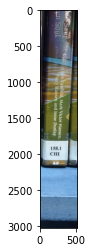

In [33]:
img = cv2.imread(img_paths[img_num])

ext_lines = sorted(ext_lines, key=lambda x: x[0])
x1, y1, x2, y2 = ext_lines[9]
x3, y3, x4, y4 = ext_lines[10]
pts =[[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
pts = np.array(pts)

rect = cv2.boundingRect(pts)
x,y,w,h = rect
cropped = img[y:y+h, x:x+w].copy()

plt.imshow(cropped)

In [ ]:
pts1 = np.array([[10,150],[150,100],[300,150],[350,100],[310,20],[35,10]])

## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = img[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
cv2.bitwise_not(bg,bg, mask=mask)
dst2 = bg+ dst

## Exploring Pytesseract and Text Localization

In [ ]:
### Regions of interest

In [2]:
len(img_paths)

8

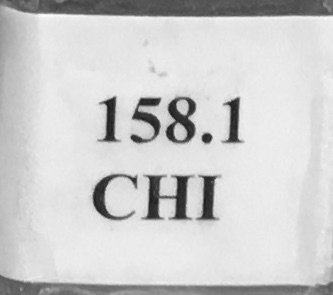

In [106]:
img_pil = Image.open(img_paths[7]).convert('L')
display(img_pil)

In [107]:
pytesseract.image_to_string(img_pil)

' \n\n158.1\nCHI\n\n \n\x0c'

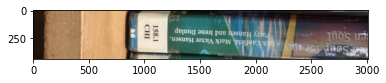

In [3]:
im = cv2.imread(img_paths[7])
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [5]:
custom_oem_psm_config = r'--psm 11'

results = pytesseract.image_to_data(im_rgb, output_type='dict', config=custom_oem_psm_config)
# results

for i in range(len(results['text'])):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    
    text = results["text"][i]
    conf = int(results["conf"][i])
    
    print(f'at {x}, {y} text = {text}')
    
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imwrite('cropped_with_boxes.jpg', im)

at 0, 0 text = 
at 1222, 66 text = 
at 1222, 66 text = 
at 1222, 66 text = 
at 1203, 62 text = Fr
at 1251, 66 text = aTo
at 1404, 123 text = 
at 1404, 123 text = 
at 1404, 123 text = 
at 1404, 123 text = *\
at 1632, 80 text = 
at 1632, 80 text = 
at 1632, 80 text = 
at 1632, 80 text = EA
at 1653, 192 text = 
at 1653, 192 text = 
at 1653, 192 text = 
at 1653, 192 text = ait
at 2758, 192 text = 
at 2758, 192 text = 
at 2758, 192 text = 
at 2758, 192 text = ><
at 1315, 206 text = 
at 1315, 206 text = 
at 1315, 206 text = 
at 1315, 206 text = a
at 2196, 160 text = 
at 2196, 160 text = 
at 2196, 160 text = 
at 2232, 156 text = Lk
at 1401, 249 text = 
at 1401, 249 text = 
at 1401, 249 text = 
at 1401, 249 text = ,8
at 1499, 260 text = 
at 1499, 260 text = 
at 1499, 260 text = 
at 1499, 260 text = ‘Jn
at 1847, 199 text = 
at 1847, 199 text = 
at 1847, 199 text = 
at 1847, 199 text = 7
at 2686, 198 text = 
at 2686, 198 text = 
at 2686, 198 text = 
at 2686, 198 text = no
at 1396, 291 text = 
at

True

In [ ]:
results.keys()

'|\n\na.\n\n\\o-\n\n=I\n\nsé\n\na\n\n=\n\n_—\n\nee\n\ned\n\nCp\n\n=a\n\nA]\n\nry =\n\n4\n\n158.1\n\nCHI\n\nLd\n\ni i\n\x0c'

In [ ]:
cropped.shape

In [ ]:
cp = cropped[1800:2200, :]
plt.imshow(cp)

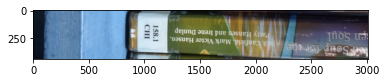

In [6]:
img = cv2.imread(img_paths[7])
plt.imshow(img)
print(pytesseract.image_to_string(img))

In [ ]:
#increased contrast
gibberish
# increased exposure
no results
#reduced exposure
no results
#increased highlights
gibberish results
#increased shadows
no results
#trimmed colors and grayscale
gibberish
#increased sharpness and grayscale
got one number
#rotating
no results

In [ ]:
kernel = np.array([[-1,-1,-1], 
                    [-1, 9,-1],
                    [-1,-1,-1]])
sharpened = cv2.filter2D(cp, -1, kernel)
plt.imshow(sharpened)

tesseract with only grayscale conversion
 
 
  

   

SLUR licy mts
Mbeki OLA TY

ore y. © aie.
— —- ee

 




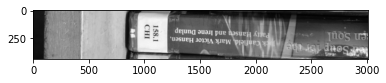

In [7]:
print('tesseract with only grayscale conversion')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,  cmap='gray')
print(pytesseract.image_to_string(gray))

tesseract with grayscale and blur
 




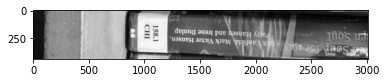

In [8]:
print('tesseract with grayscale and blur')
blur = cv2.medianBlur(gray, 3)
plt.imshow(blur, cmap='gray')
print(pytesseract.image_to_string(blur))

grayscale, smaller version (factor of 2) ------------------
(1507, 217)
 




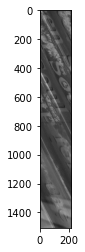

In [45]:
print('grayscale, smaller version (factor of 2) ------------------')
size = gray.shape
new_size = (int(gray.shape[0]/2), int(gray.shape[1]/2))
gray.resize(new_size)
print(gray.shape)
plt.imshow(gray, cmap='gray')
print(pytesseract.image_to_string(gray))

In [ ]:
height

In [ ]:
line = [2904, 1306, 2930, 631]
# line = [3694,  527, 3653, 1312]
height, width, _ = compare_im.shape
out = extend_line_to_bottom2(line, height)
print(out)
# out2 = extend_line_to_bottom(line, height)
# out3 = extend_line_to_top2(line)
# print(out3)

In [ ]:
x = line[::2]
y = line[1::2]
sns.scatterplot(x = x, y = y, palette=['red', 'blue'])
sns.scatterplot(x = [out[0]], y=[out[1]], palette=['green'])
# sns.scatterplot(x = [out[2]], y=[out[3]], palette=['pink'])

In [22]:
line[1::2]

NameError: name 'line' is not defined

## White label detection

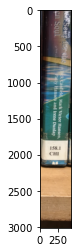

In [25]:
im = cv2.imread(img_paths[6])
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

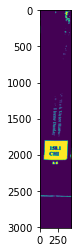

In [35]:
im_hsl = cv2.cvtColor(im, cv2.COLOR_BGR2HLS)

im_white = cv2.inRange(im_hsl,  np.array([0,200,0]), np.array([255,255,255]))
plt.imshow(im_white)

In [108]:
kernel_height = 25
kernel_move = 10
kernel_top = 0
threshold = 180
white_values = []

top_at = None
bottom_at = None
found_top = False
while(kernel_top < im_white.shape[0]):
    avg_white = np.mean(im_white[kernel_top:kernel_top+kernel_height, :])
    
    if avg_white > threshold:
        if not top_at : top_at = kernel_top + kernel_height
        else : bottom_at = kernel_top #+ kernel_height
    white_values.append(avg_white)
    
#     print(f'at {kernel_top} amount of white = {int(avg_white)}')
    kernel_top += kernel_move
print(f'top, bottom = {top_at}, {bottom_at}')

top, bottom = 1835, 2040


In [88]:
np.array(white_values).astype(int)

array([20, 16, 19, ...,  0,  0,  0])

<AxesSubplot:ylabel='Count'>

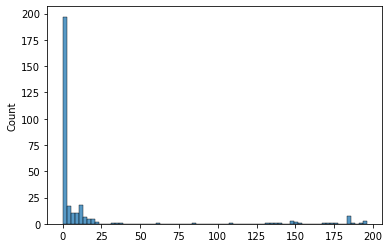

In [100]:
sns.histplot(white_values)

'158.1\nCHI\n\x0c'

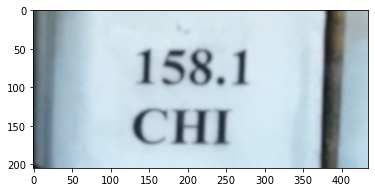

In [112]:
cropped = im[top_at:bottom_at, :].copy()
plt.imshow(cropped)
ocr_result = pytesseract.image_to_string(cropped)
ocr_result

### Convert output to a call number

In [122]:
if ocr_result:
    split_results = ocr_result.split('\n')
    if split_results[0].replace('.',"").isnumeric() and split_results[1].isalpha():
        call_number = (split_results[0], split_results[1])
call_number

('158.1', 'CHI')

In [117]:
i = '158.1'
i.replace('.','',1).isnumeric()

True

In [131]:
i = ('158.1', 'CHI')
t = ('158.1', 'BED')
i < t

False

In [ ]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def pad_image(img):
       old_image_height, old_image_width, channels = labels[2].shape

       # create new image of desired size and color (blue) for padding
       new_image_width = 300
       new_image_height = 300
       color = (255,255,255)
       result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

       # compute center offset
       x_center = (new_image_width - old_image_width) // 2
       y_center = (new_image_height - old_image_height) // 2

       # copy img image into center of result image
       result[y_center:y_center+old_image_height, 
              x_center:x_center+old_image_width] = labels[2]

       return result

In [ ]:
inst = cv2.xphoto.createGrayworldWB()
inst.setSaturationThreshold(0.99)
new_im = inst.balanceWhite(labels[0])

new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY)
pytesseract.image_to_string(new_im)

In [ ]:
print(labels[0].shape)

c = labels[0][15:80, 35:90]
plt.imshow(c)

In [ ]:
#  img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
img = cv2.resize(labels[2], None, fx=2, fy=2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for psm in range(6,13+1):
    config = '--oem 3 --psm %d' % psm
    txt = pytesseract.image_to_string(img, config = config, lang='eng')
    print('psm ', psm, ':',txt)